In [1]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-xpv1ctyn
  Running command git clone -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-xpv1ctyn
  Created wheel for bgs-sv: filename=bgs_sv-0.0-py3-none-any.whl size=1088144 sha256=35f22c5881d861b8dd2664c51cdf0d59bf27c3836a526909d934affc353caf0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-2db023sb/wheels/c5/7b/33/3fa8f7338087a37e7ad7a1378e08d97458e5dbab577a10268f
Successfully built bgs-sv
  Attempting uninstall: bgs-sv
    Found existing installation: bgs-sv 0.0
    Uninstalling bgs-sv-0.0:
      Successfully uninstalled bgs-sv-0.0


In [2]:
import numpy as np 
import astropy.table as atable
import matplotlib.pyplot as plt

from bgs_sv import sv1

# read single exposures from Cascades reduction

In [3]:
# read in deep exposures
deep = sv1.cascades_deep_exposures()
# read in single exposures
exps = sv1.cascades_nexp1_exposures()

In [4]:
# only keep tiles with deep with effective exposure time longer than 1000s
verydeep = (deep['R_DEPTH_EBVAIR'] > 1000.)
print('%i of %i tiles have eff exposure time > 1000s' % (np.sum(verydeep), len(verydeep)))

70 of 109 tiles have eff exposure time > 1000s


In [5]:
# only keep single exposures on tiles with eff exp time > 1000s
exps = exps[np.isin(exps['TILEID'], deep['TILEID'][verydeep])]

# exposures with `EFFTIME_BRIGHT ~ 180`

In [33]:
exps.colnames

['NIGHT',
 'EXPID',
 'FIELD',
 'TARGETS',
 'OBSCONDITIONS',
 'ARIZONA_TIMEOBS',
 'EBV',
 'SPECMODEL_SKY_GFLUX',
 'SPECMODEL_SKY_RFLUX',
 'SPECMODEL_SKY_ZFLUX',
 'GFA_ORIGIN',
 'B_DEPTH',
 'R_DEPTH',
 'Z_DEPTH',
 'B_DEPTH_EBVAIR',
 'R_DEPTH_EBVAIR',
 'Z_DEPTH_EBVAIR',
 'EFFTIME_DARK',
 'EFFTIME_BRIGHT',
 'EFFTIME_BACKUP',
 'SPEED_DARK',
 'SPEED_BRIGHT',
 'SPEED_BACKUP',
 'SPECPROD',
 'SPECPROD_BITPSFFN',
 'SPECPROD_BITFRAMEFN',
 'SPECPROD_BITSKYFN',
 'SPECPROD_BITSFRAMEFN',
 'SPECPROD_BITFLUXCALIBFN',
 'SPECPROD_BITCFRAMEFN',
 'TSNR2_BGS',
 'TSNR2_LRG',
 'TSNR2_ELG',
 'TSNR2_QSO',
 'TILEID',
 'TILERA',
 'TILEDEC',
 'EXPTIME',
 'MJDOBS',
 'N_ASSGN_TGT',
 'N_ASSGN_SKY',
 'N_ASSGN_STD',
 'N_ASSGN_WD',
 'N_ASSGN_LRG',
 'N_ASSGN_ELG',
 'N_ASSGN_QSO',
 'N_ASSGN_BGS',
 'N_ASSGN_MWS',
 'SKYMON_NEXP',
 'SKYMON_SKYCAM0_MEAN',
 'SKYMON_SKYCAM0_MEAN_ERR',
 'SKYMON_SKYCAM1_MEAN',
 'SKYMON_SKYCAM1_MEAN_ERR',
 'SKYMON_AVERAGE_MEAN',
 'SKYMON_AVERAGE_MEAN_ERR',
 'GFA_AIRMASS',
 'GFA_MOON_ILLUMINATION',

In [34]:
is_bgs = (exps['TARGETS'] == 'BGS+MWS')
print('%i of %i exposures are BGS exposures' % (np.sum(is_bgs), len(is_bgs)))

#r_depth_ebvair = 180
#d_r_depth_ebvair = 20
#close_to_nominal = np.abs(exps['R_DEPTH_EBVAIR'] - r_depth_ebvair) < d_r_depth_ebvair

#https://desi.lbl.gov/trac/wiki/SurveyOps/SurveySpeed
efftime = 180
d_efftime = 10
close_to_nominal = np.abs(exps['EFFTIME_BRIGHT'] - efftime) < d_efftime

bgs_exps = exps[is_bgs & close_to_nominal]
print(bgs_exps['TILEID', 'NIGHT', 'EXPID', 'EXPTIME', 'EFFTIME_BRIGHT', 'GFA_SKY_MAG_AB'])
print('%i BGS exposures with deep and are close to nominal' % len(bgs_exps))

290 of 834 exposures are BGS exposures
TILEID  NIGHT   EXPID EXPTIME  EFFTIME_BRIGHT GFA_SKY_MAG_AB
                      seconds     seconds                   
------ -------- ----- -------- -------------- --------------
 80619 20201218 68673    300.0      176.86868      20.656513
 80619 20201218 68674    300.0      173.16583      20.617075
 80617 20201219 68799    300.0      176.34781      20.746029
 80617 20201219 68801    300.0      176.36574      20.784819
 80643 20210103 70734    300.0      177.25772      20.116116
 80643 20210103 70735    300.0      171.86566      20.098228
 80643 20210103 70736    300.0      172.80205      20.090168
 80644 20210103 70737    300.0      176.05934      19.991714
 80660 20210103 70762    300.0       170.5845      19.748405
 80660 20210103 70763    300.0      170.71529      19.774368
 80644 20210106 71115 300.0791      183.01369      20.694523
 80645 20210106 71116 300.0604      176.09325       20.77025
 80646 20210107 71273 300.0785      181.91461 

# $z$ success rate
To quantify $z$ success rate, we use the DEEP exposures as the truth table. 
For each tile, we only consider BGS SV targets that meet the following criteria from the DEEP exposure: 
- ZWARN = 0
- DELTACHI2 > 40
- SPECTYPE != 'STAR'
- 0. < Z < 0.6
- ZERR < 0.0005 (1 + Z)
Any targets that do not meet these criteria are considered targeting issues. 

Out of these targets we determine redshift success for SINGLE expsoures if the following criteria are met: 
- ZWARN = 0
- DELTACHI2 > 40
- SPECTYPE != 'STAR'
- 0. < Z < 0.6
- ZERR < 0.0005 (1 + Z)
- |Z - Z_DEEP| / (1+Z_DEEP) < 0.003  where Z_DEEP is the redrock redshit for DEEP exposure

In [7]:
def zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2):
    ''' measure the redshift success rate along with property `prop`

    :params prop: 
        array of properties (i.e. Legacy r-band magnitude) 

    :params zsuccess_cond:
        boolean array indicating redshift success 

    :params range: (default: None) 
        range of the `prop` 

    :params nbins: (default: 20) 
        number of bins to divide `prop` by 
    
    :params bin_min: (default: 2)  
        minimum number of objects in bin to exlcude it 

    :return wmean: 
        weighted mean of `prop` in the bins 

    :return e1: 
        redshift success rate in the bins

    :return ee1: 
        simple poisson error on the success rate
    '''
    h0, bins = np.histogram(prop, bins=nbins, range=range)
    hv, _ = np.histogram(prop, bins=bins, weights=prop)
    h1, _ = np.histogram(prop[zsuccess_cond], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    wmean = hv / h0 # weighted mean 
    rate = h1.astype("float") / (h0.astype('float') + (h0==0))
    e_rate = np.sqrt(rate * (1 - rate)) / np.sqrt(h0.astype('float') + (h0 == 0))
    return wmean, rate, e_rate

In [8]:
def get_exp_zsuccess(tileid, night, expid): 
    ''' get redshift success rate for given exposure for ALL BGS SV targets
    '''
    # get redrock output for DEEP exposure for BGS_ANY targets
    _zbest_deep = sv1.get_zbest(tileid, 'deep', targetclass='all', redux='cascades')
    
    crit_zwarn = (_zbest_deep['ZWARN'] == 0)
    crit_dchi2 = (_zbest_deep['DELTACHI2']  > 40.) 
    crit_stype = (_zbest_deep['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (_zbest_deep['Z'] > 0.0) & (_zbest_deep['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (_zbest_deep['ZERR'] < (0.0005 * (1. + _zbest_deep['Z'])))
    
    truth_table = crit_dchi2 & crit_stype & crit_z_lim & crit_z_err
    zbest_deep = _zbest_deep[truth_table]['TARGETID', 'Z']
    # redrock redshifts from DEEP exposure will be used as true redshifts
    zbest_deep.rename_column('Z', 'Z_TRUE')
    
    # get redrock output for SINGLE exposure for BGS_ANY targets
    zbest_exp = sv1.get_zbest(tileid, night, expid=expid, targetclass='all', redux='cascades')

    # only keep targets that are in the deep
    zbest_exp = atable.join(zbest_deep, zbest_exp, keys='TARGETID', join_type='inner')
    
    crit_zwarn = (zbest_exp['ZWARN'] == 0)
    crit_dchi2 = (zbest_exp['DELTACHI2']  > 40.) 
    crit_stype = (zbest_exp['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (zbest_exp['Z'] > 0.0) & (zbest_exp['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (zbest_exp['ZERR'] < (0.0005 * (1. + zbest_exp['Z'])))
    
    dz_1pz = np.abs(zbest_exp['Z_TRUE'] - zbest_exp['Z']) / (1. + zbest_exp['Z_TRUE'])
    crit_ztrue = (dz_1pz < 0.003)

    # combine all criteria
    zsuccess = crit_zwarn & crit_dchi2 & crit_stype & crit_z_lim & crit_z_err & crit_ztrue
    return zbest_exp, zsuccess

In [9]:
_g_mags, _r_mags, _z_mags, _w1_mags, _w2_mags, _r_fibmags, _zss = [], [], [], [], [], [], []
for rdepth, tileid, night, expid in zip(bgs_exps['R_DEPTH_EBVAIR'], bgs_exps['TILEID'], bgs_exps['NIGHT'], bgs_exps['EXPID']):
    _zbest, _zs = get_exp_zsuccess(tileid, night, expid)
    _g_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_G'])))
    _r_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_R'])))
    _z_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_Z'])))
    _w1_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_W1'])))
    _w2_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_W2'])))
    _r_fibmags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FIBERFLUX_R'])))
    _zss.append(_zs)
    
g_mags = np.concatenate(_g_mags)
r_mags = np.concatenate(_r_mags)    
z_mags = np.concatenate(_z_mags)
w1_mags = np.concatenate(_w1_mags)
w2_mags = np.concatenate(_w2_mags)
r_fibmags = np.concatenate(_r_fibmags)
zss = np.array(np.concatenate(_zss))

<ipython-input-9-f0499dcde152>:4: RuntimeWarning: divide by zero encountered in log10
  _g_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_G'])))
<ipython-input-9-f0499dcde152>:6: RuntimeWarning: invalid value encountered in log10
  _z_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_Z'])))
<ipython-input-9-f0499dcde152>:7: RuntimeWarning: invalid value encountered in log10
  _w1_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_W1'])))
<ipython-input-9-f0499dcde152>:8: RuntimeWarning: invalid value encountered in log10
  _w2_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_W2'])))


 /global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80643/deep/zbest-3-80643-deep.fits does not exist
 /global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80643/exposures/zbest-3-80643-00070734.fits does not exist


<ipython-input-9-f0499dcde152>:4: RuntimeWarning: invalid value encountered in log10
  _g_mags.append(22.5 - 2.5 * np.log10(np.array(_zbest['FLUX_G'])))


 /global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80643/deep/zbest-3-80643-deep.fits does not exist
 /global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80643/exposures/zbest-3-80643-00070735.fits does not exist
 /global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80643/deep/zbest-3-80643-deep.fits does not exist
 /global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80643/exposures/zbest-3-80643-00070736.fits does not exist
 /global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80644/deep/zbest-3-80644-deep.fits does not exist
 /global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80644/exposures/zbest-3-80644-00070737.fits does not exist
 /global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80660/deep/zbest-3-80660-deep.fits does not exist
 /global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80660/exposures/zbest-3-80660-00070762.fits does not exist
 /global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80660/deep/zbest-3-80660-deep.fits does not exist
 /global/cfs/cdirs/desi/spectro/redux

In [10]:
print('%i targets total' % len(r_mags))

32693 targets total


# overall redshift success rate

Text(0, 0.5, '$z$ success rate')

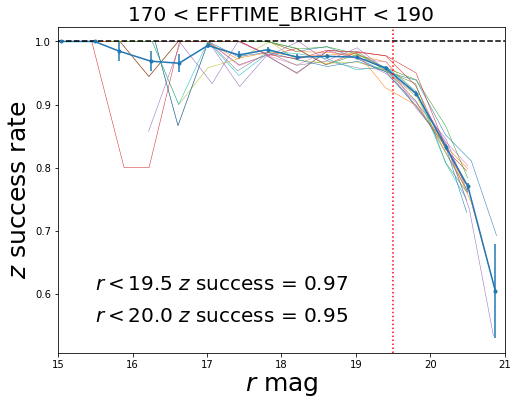

In [13]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

for _r_mag, _zs in zip(_r_mags, _zss): 
    r_mid, zs, zs_err = zsuccess_rate(_r_mag, _zs, range=(14, 22), nbins=20)
    sub.plot(r_mid, zs, lw=0.5)
    
r_mid, zs, zs_err = zsuccess_rate(r_mags, zss, range=(14, 22), nbins=20)
sub.errorbar(r_mid, zs, yerr=zs_err, fmt='.C0')
sub.plot(r_mid, zs, c='C0')
sub.axhline(1., linestyle='--', color='k')

sub.text(15.5, 0.6, '$r < 19.5$ $z$ success = %.2f' % (np.sum(zss[r_mags < 19.5])/np.sum(r_mags < 19.5)), ha='left', va='bottom', fontsize=20) 
sub.text(15.5, 0.55, '$r < 20.0$ $z$ success = %.2f' % (np.sum(zss[r_mags < 20.0])/np.sum(r_mags < 20.0)), ha='left', va='bottom', fontsize=20) 

#sub.set_title("%.f < R_DEPTH_EBVAIR < %.f" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)
sub.set_title("%.f < EFFTIME_BRIGHT < %.f" % (efftime - d_efftime, efftime + d_efftime), fontsize=20)
sub.axvline(19.5, c='r', ls=':')
sub.set_xlabel('$r$ mag', fontsize=25)
sub.set_xlim(15, 21)
sub.set_ylabel('$z$ success rate', fontsize=25)

Text(0, 0.5, '$z$ success rate')

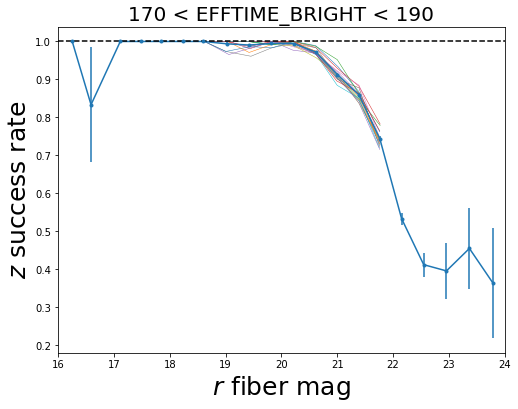

In [15]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

for _r_fibmag, _zs in zip(_r_fibmags, _zss): 
    r_mid, zs, zs_err = zsuccess_rate(_r_fibmag, _zs, range=(14, 22), nbins=20)
    sub.plot(r_mid, zs, lw=0.5)

r_mid, zs, zs_err = zsuccess_rate(r_fibmags, zss, range=(16, 24), nbins=20)
sub.errorbar(r_mid, zs, yerr=zs_err, fmt='.C0')
sub.plot(r_mid, zs, c='C0')
sub.axhline(1., linestyle='--', color='k')
#sub.set_title("%.f < R_DEPTH_EBVAIR < %.f" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)
sub.set_title("%.f < EFFTIME_BRIGHT < %.f" % (efftime - d_efftime, efftime + d_efftime), fontsize=20)
sub.set_xlabel('$r$ fiber mag', fontsize=25)
sub.set_xlim(16, 24)
sub.set_ylabel('$z$ success rate', fontsize=25)

Text(0.5, 0.98, '170 < EFFTIME_BRIGHT < 190')

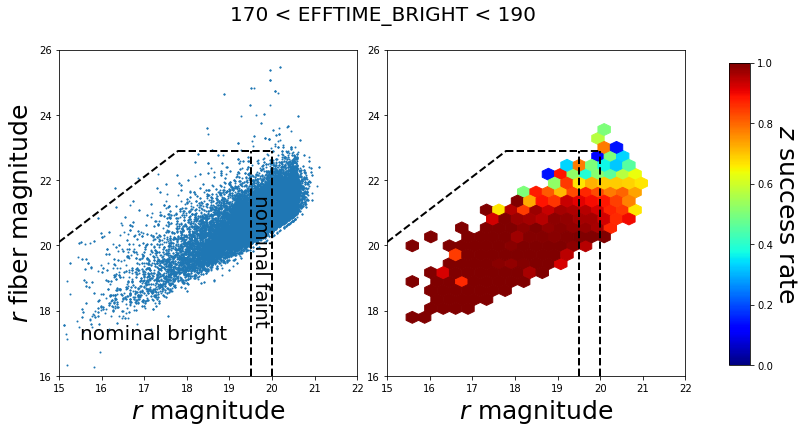

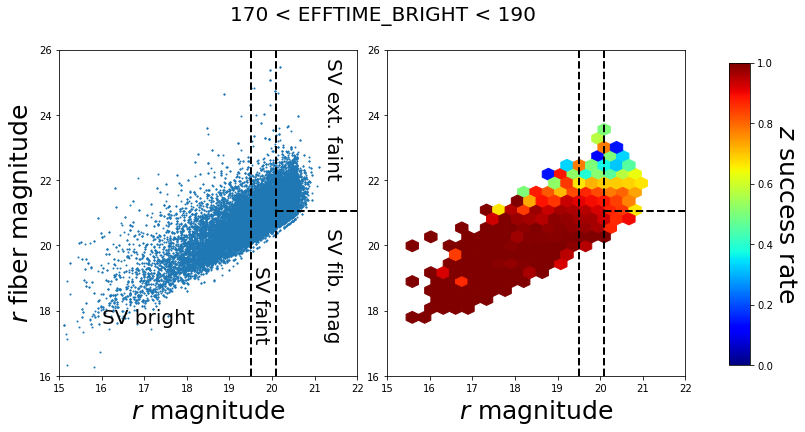

In [17]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_mags, r_fibmags, c='C0', s=1)
sub.plot([15, 17.8], [20.1, 22.9], c='k', ls='--', lw=2)
sub.plot([17.8, 20.], [22.9, 22.9], c='k', ls='--', lw=2)
sub.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=2)
sub.plot([20., 20.], [16., 22.9], c='k', ls='--', lw=2)
sub.text(15.5, 17.0, 'nominal bright', ha='left', va='bottom', fontsize=20) 
sub.text(19.5, 17.5, 'nominal faint', ha='left', va='bottom', rotation=270, fontsize=20) 
sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylabel('$r$ fiber magnitude', fontsize=25)
sub.set_ylim(16, 26)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_mags, r_fibmags, C=zss.astype(float), reduce_C_function=np.mean, gridsize=30, vmin=0., vmax=1., mincnt=5, cmap='jet')
sub.plot([15, 17.8], [20.1, 22.9], c='k', ls='--', lw=2)
sub.plot([17.8, 20.], [22.9, 22.9], c='k', ls='--', lw=2)
sub.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=2)
sub.plot([20., 20.], [16., 22.9], c='k', ls='--', lw=2)

sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylim(16, 26)
#sub.set_title("%.f < R_DEPTH_EBVAIR < %.f, MINCNT>5" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
fig.suptitle("%.f < EFFTIME_BRIGHT < %.f" % (efftime - d_efftime, efftime + d_efftime), fontsize=20)

fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_mags, r_fibmags, c='C0', s=1)
sub.axvline(19.5, linewidth=2, linestyle='--', color='k')
sub.axvline(20.1, linewidth=2, linestyle='--', color='k')
sub.plot([20.1, 22.], [21.051, 21.051], c='k', ls='--', lw=2)
sub.text(16.0, 17.5, 'SV bright', ha='left', va='bottom', fontsize=20) 
sub.text(19.5, 17.0, 'SV faint', ha='left', va='bottom', rotation=270, fontsize=20) 
sub.text(21.2, 17.0, 'SV fib. mag', ha='left', va='bottom', rotation=270, fontsize=20) 
sub.text(21.2, 22.0, 'SV ext. faint', ha='left', va='bottom', rotation=270, fontsize=20) 
sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylabel('$r$ fiber magnitude', fontsize=25)
sub.set_ylim(16, 26)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_mags, r_fibmags, C=zss.astype(float), reduce_C_function=np.mean, gridsize=30, vmin=0., vmax=1., mincnt=5, cmap='jet')
sub.axvline(19.5, linewidth=2, linestyle='--', color='k')
sub.axvline(20.1, linewidth=2, linestyle='--', color='k')
sub.plot([20.1, 22.], [21.051, 21.051], c='k', ls='--', lw=2)

sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 22)
sub.set_ylim(16, 26)
#sub.set_title("%.f < R_DEPTH_EBVAIR < %.f, MINCNT>5" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)

fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
fig.suptitle("%.f < EFFTIME_BRIGHT < %.f" % (efftime - d_efftime, efftime + d_efftime), fontsize=20)

Text(0, 0.5, '$z$ success rate')

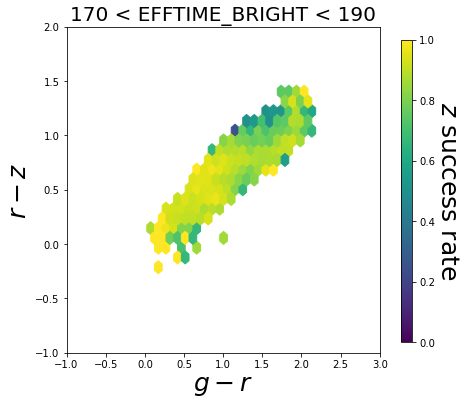

In [18]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
hb = sub.hexbin(g_mags - r_mags, r_mags - z_mags, C=zss.astype(float), reduce_C_function=np.mean, gridsize=50, vmin=0., vmax=1., mincnt=5)
sub.set_xlabel('$g - r$', fontsize=25)
sub.set_xlim(-1, 3)
sub.set_ylabel('$r - z$', fontsize=25)
sub.set_ylim(-1, 2)
#sub.set_title("%.f < R_DEPTH_EBVAIR < %.f, MINCNT>5" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)
sub.set_title("%.f < EFFTIME_BRIGHT < %.f" % (efftime - d_efftime, efftime + d_efftime), fontsize=20)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)

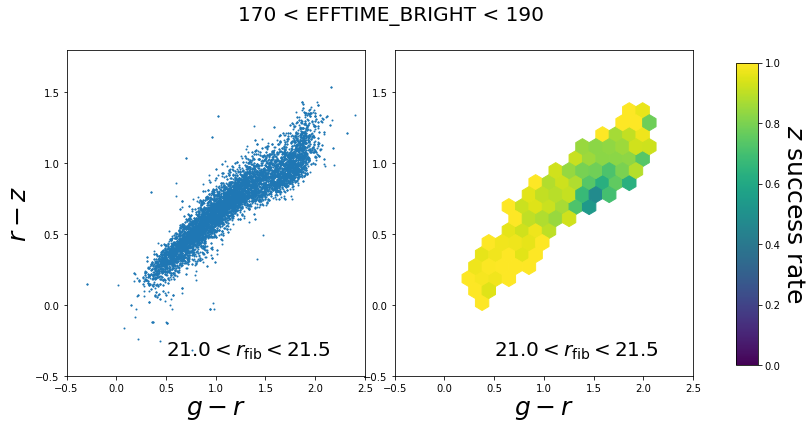

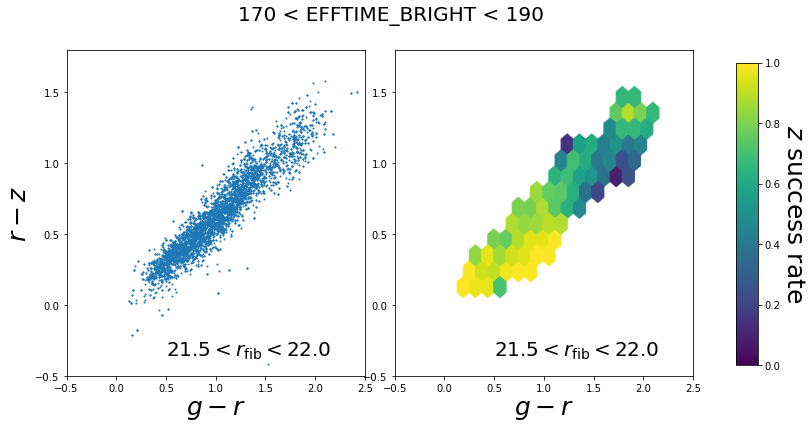

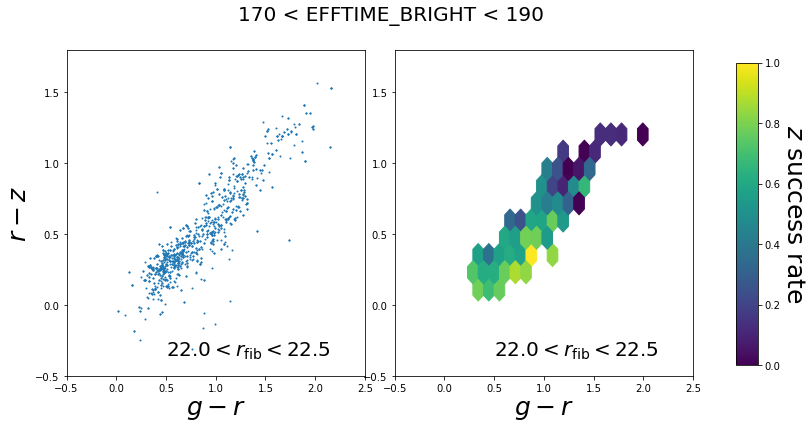

In [19]:
for r_fibmag_low, r_fibmag_high in zip([21., 21.5, 22.], [21.5, 22., 22.5]): 
    rfiblim = (r_fibmags > r_fibmag_low) & (r_fibmags < r_fibmag_high)
    gr = (g_mags - r_mags)[rfiblim]
    rz = (r_mags - z_mags)[rfiblim]
    
    fig = plt.figure(figsize=(12,6))
    sub = fig.add_subplot(121)
    sub.scatter(gr, rz, c='C0', s=1)
    sub.text(0.5, -0.25, r'$%.1f < r_{\rm fib} < %.1f$' % (r_fibmag_low, r_fibmag_high), ha='left', va='top', fontsize=20)
    sub.set_xlabel('$g - r$', fontsize=25)
    sub.set_xlim(-0.5, 2.5)
    sub.set_ylabel('$r - z$', fontsize=25)
    sub.set_ylim(-0.5, 1.8)
    
    sub = fig.add_subplot(122)
    hb = sub.hexbin(gr, rz, C=zss[rfiblim].astype(float), reduce_C_function=np.mean, gridsize=20, vmin=0., vmax=1., mincnt=5)
    sub.text(0.5, -0.25, r'$%.1f < r_{\rm fib} < %.1f$' % (r_fibmag_low, r_fibmag_high), ha='left', va='top', fontsize=20)
    sub.set_xlabel('$g - r$', fontsize=25)
    sub.set_xlim(-0.5, 2.5)
    sub.set_ylim(-0.5, 1.8)
    #sub.set_title("%.f < R_DEPTH_EBVAIR < %.f, MINCNT>5" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)
    fig.suptitle("%.f < EFFTIME_BRIGHT < %.f" % (efftime - d_efftime, efftime + d_efftime), fontsize=20)

    fig.subplots_adjust(wspace=0.1, right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)

In [21]:
schlegel_color = (z_mags - w1_mags) - 3/2.5 * (g_mags - r_mags) + 1.2

Text(0, 0.5, '$z$ success rate')

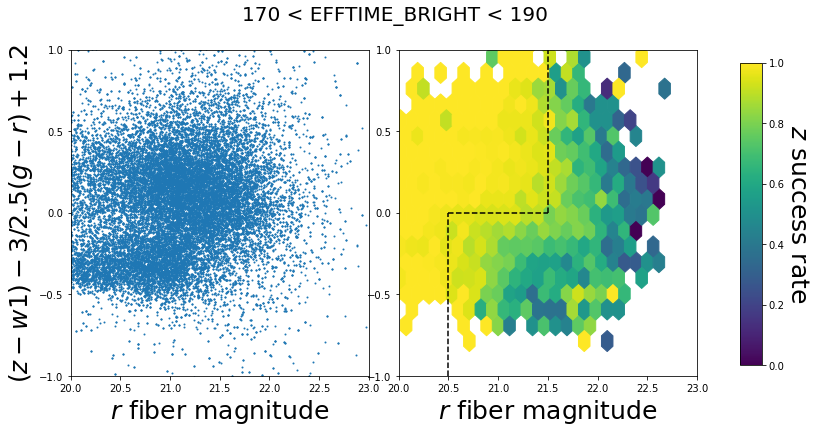

In [22]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_fibmags, schlegel_color, c='C0', s=1)
sub.set_ylabel('$(z - w1) - 3/2.5 (g - r) + 1.2$', fontsize=25)
sub.set_yticks([-1., -0.5, 0., 0.5, 1.])
sub.set_ylim(-1, 1.)
sub.set_xlabel('$r$ fiber magnitude', fontsize=25)
sub.set_xlim(20, 23)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_fibmags, schlegel_color, C=zss.astype(float), reduce_C_function=np.mean, gridsize=80, vmin=0., vmax=1., mincnt=5)
sub.plot([20.5, 20.5], [-1, 0.], c='k', ls='--')
sub.plot([20.5, 21.5], [0., 0.], c='k', ls='--')
sub.plot([21.5, 21.5], [0., 1.], c='k', ls='--')
sub.set_yticks([-1., -0.5, 0., 0.5, 1.])
sub.set_ylim(-1, 1.)
sub.set_xlabel('$r$ fiber magnitude', fontsize=25)
sub.set_xlim(20, 23)
#sub.set_title("%.f < R_DEPTH_EBVAIR < %.f, MINCNT>5" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)

fig.suptitle("%.f < EFFTIME_BRIGHT < %.f" % (efftime - d_efftime, efftime + d_efftime), fontsize=20)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)

Text(0, 0.5, '$z$ success rate')

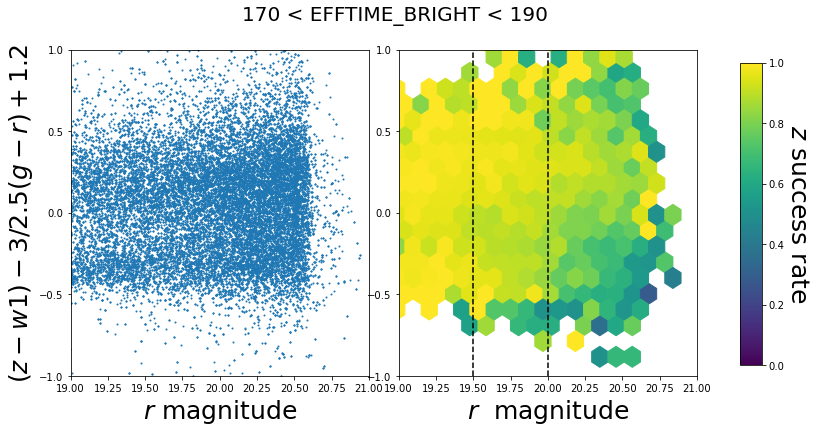

In [23]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_mags, schlegel_color, c='C0', s=1)
sub.set_ylabel('$(z - w1) - 3/2.5 (g - r) + 1.2$', fontsize=25)
sub.set_yticks([-1., -0.5, 0., 0.5, 1.])
sub.set_ylim(-1, 1.)
sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(19., 21)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_mags, schlegel_color, C=zss.astype(float), reduce_C_function=np.mean, gridsize=80, vmin=0., vmax=1., mincnt=5)
sub.plot([19.5, 19.5], [-1, 1.], c='k', ls='--')
sub.plot([20., 20.], [-1, 1.], c='k', ls='--')
#sub.plot([20.5, 20.5], [-1, 0.], c='k', ls='--')
#sub.plot([20.5, 21.5], [0., 0.], c='k', ls='--')
#sub.plot([21.5, 21.5], [0., 1.], c='k', ls='--')
sub.set_yticks([-1., -0.5, 0., 0.5, 1.])
sub.set_ylim(-1, 1.)
sub.set_xlabel('$r$  magnitude', fontsize=25)
sub.set_xlim(19, 21)
fig.suptitle("%.f < EFFTIME_BRIGHT < %.f" % (efftime - d_efftime, efftime + d_efftime), fontsize=20)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)

In [24]:
fiber_color_cut_a = (r_fibmags < 20.5) | ((r_fibmags < 21.5) & (schlegel_color > 0.))
fiber_color_cut_b = (r_fibmags < 20.75) | ((r_fibmags < 21.75) & (schlegel_color > 0.))
fiber_color_cut_c = (r_fibmags < 21.0) | ((r_fibmags < 22.0) & (schlegel_color > 0.))
fiber_color_cut_d = (r_fibmags < 21.25) | ((r_fibmags < 22.25) & (schlegel_color > 0.))
fiber_color_cut_e = (r_fibmags < 21.5) | ((r_fibmags < 22.5) & (schlegel_color > 0.))

a 0.99
b 0.95
c 0.94
d 0.86
e 0.85


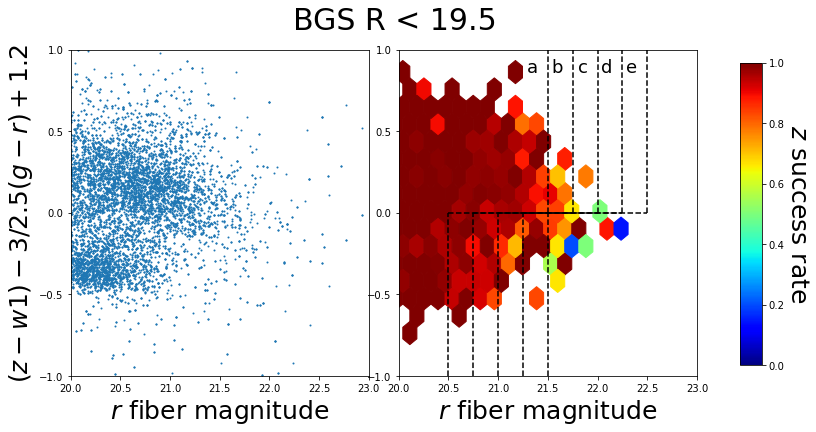

In [29]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_fibmags[r_mags < 19.5], schlegel_color[r_mags < 19.5], c='C0', s=1)
sub.set_ylabel('$(z - w1) - 3/2.5 (g - r) + 1.2$', fontsize=25)
sub.set_yticks([-1., -0.5, 0., 0.5, 1.])
sub.set_ylim(-1, 1.)
sub.set_xlabel('$r$ fiber magnitude', fontsize=25)
sub.set_xlim(20, 23)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_fibmags[r_mags < 19.5], schlegel_color[r_mags < 19.5], C=zss.astype(float)[r_mags < 19.5], reduce_C_function=np.mean, gridsize=60, vmin=0., vmax=1., mincnt=5, cmap='jet')
for i in range(5): 
    sub.plot([20.5 + 0.25 * i, 20.5 + 0.25 * i], [-1, 0.], c='k', ls='--')
    sub.plot([20.5 + 0.25 * i, 21.5 + 0.25 * i], [0., 0.], c='k', ls='--')
    sub.plot([21.5 + 0.25 * i, 21.5 + 0.25 * i], [0., 1.], c='k', ls='--')
    sub.text(21.4 + 0.25 * i, 0.95, ['a', 'b', 'c', 'd', 'e'][i], ha='right', va='top', fontsize=18)

sub.set_yticks([-1., -0.5, 0., 0.5, 1.])
sub.set_ylim(-1, 1.)
sub.set_xlabel('$r$ fiber magnitude', fontsize=25)
sub.set_xlim(20, 23)
#sub.set_title("%.f < R_DEPTH_EBVAIR < %.f, MINCNT>5" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
fig.suptitle('BGS R < 19.5', fontsize=30)

print('a %.2f' % np.mean(zss[(r_mags < 19.5) & fiber_color_cut_a]))
print('b %.2f' % np.mean(zss[(r_mags < 19.5) & fiber_color_cut_b & ~fiber_color_cut_a]))
print('c %.2f' % np.mean(zss[(r_mags < 19.5) & fiber_color_cut_c & ~fiber_color_cut_b]))
print('d %.2f' % np.mean(zss[(r_mags < 19.5) & fiber_color_cut_d & ~fiber_color_cut_c]))
print('e %.2f' % np.mean(zss[(r_mags < 19.5) & fiber_color_cut_e & ~fiber_color_cut_d]))

a 0.99
b 0.93
c 0.91
d 0.83
e 0.81


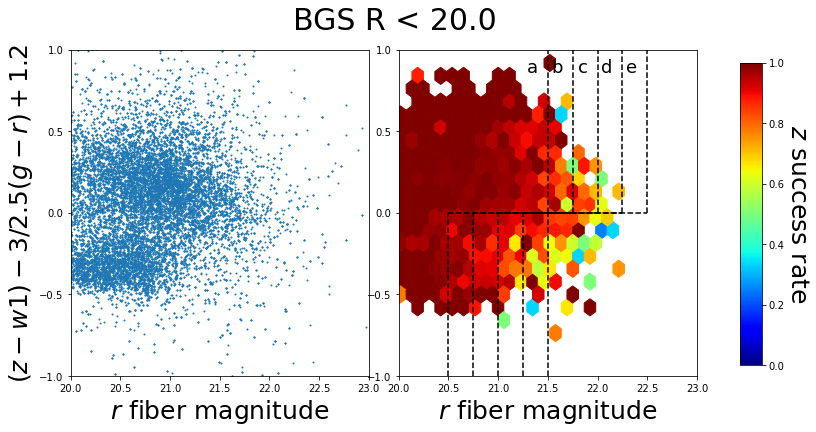

In [30]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_fibmags[r_mags < 20], schlegel_color[r_mags < 20], c='C0', s=1)
sub.set_ylabel('$(z - w1) - 3/2.5 (g - r) + 1.2$', fontsize=25)
sub.set_yticks([-1., -0.5, 0., 0.5, 1.])
sub.set_ylim(-1, 1.)
sub.set_xlabel('$r$ fiber magnitude', fontsize=25)
sub.set_xlim(20, 23)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_fibmags[r_mags < 20], schlegel_color[r_mags < 20], C=zss.astype(float)[r_mags < 20], reduce_C_function=np.mean, gridsize=80, vmin=0., vmax=1., mincnt=5, cmap='jet')
for i in range(5): 
    sub.plot([20.5 + 0.25 * i, 20.5 + 0.25 * i], [-1, 0.], c='k', ls='--')
    sub.plot([20.5 + 0.25 * i, 21.5 + 0.25 * i], [0., 0.], c='k', ls='--')
    sub.plot([21.5 + 0.25 * i, 21.5 + 0.25 * i], [0., 1.], c='k', ls='--')
    sub.text(21.4 + 0.25 * i, 0.95, ['a', 'b', 'c', 'd', 'e'][i], ha='right', va='top', fontsize=18)

sub.set_yticks([-1., -0.5, 0., 0.5, 1.])
sub.set_ylim(-1, 1.)
sub.set_xlabel('$r$ fiber magnitude', fontsize=25)
sub.set_xlim(20, 23)
#sub.set_title("%.f < R_DEPTH_EBVAIR < %.f, MINCNT>5" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
fig.suptitle('BGS R < 20.0', fontsize=30)

print('a %.2f' % np.mean(zss[(r_mags < 20.0) & fiber_color_cut_a]))
print('b %.2f' % np.mean(zss[(r_mags < 20.0) & fiber_color_cut_b & ~fiber_color_cut_a]))
print('c %.2f' % np.mean(zss[(r_mags < 20.0) & fiber_color_cut_c & ~fiber_color_cut_b]))
print('d %.2f' % np.mean(zss[(r_mags < 20.0) & fiber_color_cut_d & ~fiber_color_cut_c]))
print('e %.2f' % np.mean(zss[(r_mags < 20.0) & fiber_color_cut_e & ~fiber_color_cut_d]))

a 0.98
b 0.92
c 0.89
d 0.81
e 0.78


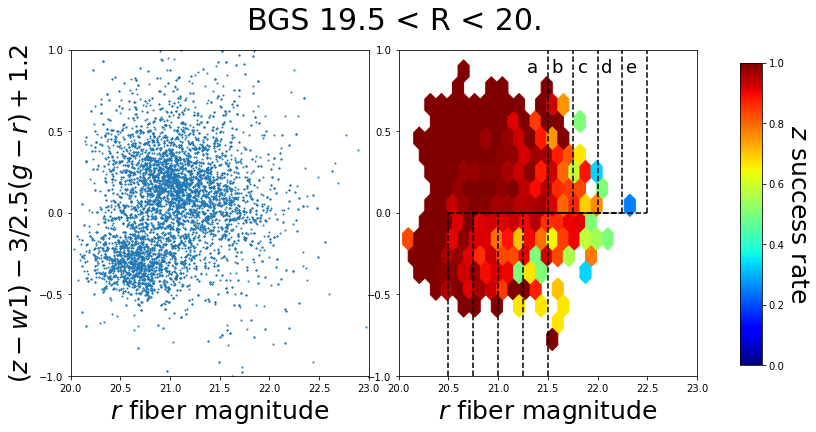

In [31]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(r_fibmags[(r_mags > 19.5) & (r_mags < 20.)], schlegel_color[(r_mags > 19.5) & (r_mags < 20.)], c='C0', s=1)
sub.set_ylabel('$(z - w1) - 3/2.5 (g - r) + 1.2$', fontsize=25)
sub.set_yticks([-1., -0.5, 0., 0.5, 1.])
sub.set_ylim(-1, 1.)
sub.set_xlabel('$r$ fiber magnitude', fontsize=25)
sub.set_xlim(20, 23)

sub = fig.add_subplot(122)
hb = sub.hexbin(r_fibmags[(r_mags > 19.5) & (r_mags < 20.)], schlegel_color[(r_mags > 19.5) & (r_mags < 20.)], 
                C=zss.astype(float)[(r_mags > 19.5) & (r_mags < 20.)], reduce_C_function=np.mean, gridsize=50, vmin=0., vmax=1., mincnt=5, cmap='jet')
for i in range(5): 
    sub.plot([20.5 + 0.25 * i, 20.5 + 0.25 * i], [-1, 0.], c='k', ls='--')
    sub.plot([20.5 + 0.25 * i, 21.5 + 0.25 * i], [0., 0.], c='k', ls='--')
    sub.plot([21.5 + 0.25 * i, 21.5 + 0.25 * i], [0., 1.], c='k', ls='--')
    sub.text(21.4 + 0.25 * i, 0.95, ['a', 'b', 'c', 'd', 'e'][i], ha='right', va='top', fontsize=18)

sub.set_yticks([-1., -0.5, 0., 0.5, 1.])
sub.set_ylim(-1, 1.)
sub.set_xlabel('$r$ fiber magnitude', fontsize=25)
sub.set_xlim(20, 23)
#sub.set_title("%.f < R_DEPTH_EBVAIR < %.f, MINCNT>5" % (r_depth_ebvair - 0.5 * d_r_depth_ebvair, r_depth_ebvair + 0.5 * d_r_depth_ebvair), fontsize=20)
fig.subplots_adjust(wspace=0.1, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'$z$ success rate', labelpad=25, fontsize=25, rotation=270)
fig.suptitle('BGS 19.5 < R < 20.', fontsize=30)


print('a %.2f' % np.mean(zss[(r_mags > 19.5) & (r_mags < 20.0) & fiber_color_cut_a]))
print('b %.2f' % np.mean(zss[(r_mags > 19.5) & (r_mags < 20.0) & fiber_color_cut_b & ~fiber_color_cut_a]))
print('c %.2f' % np.mean(zss[(r_mags > 19.5) & (r_mags < 20.0) & fiber_color_cut_c & ~fiber_color_cut_b]))
print('d %.2f' % np.mean(zss[(r_mags > 19.5) & (r_mags < 20.0) & fiber_color_cut_d & ~fiber_color_cut_c]))
print('e %.2f' % np.mean(zss[(r_mags > 19.5) & (r_mags < 20.0) & fiber_color_cut_e & ~fiber_color_cut_d]))